# Imports 

In [1]:
import pandas as pd
import numpy as np
import torch
import random
import os
import glob
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch.nn as nn
import sys
import wordcloud
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from tqdm.notebook import tqdm
tqdm.pandas()

from transformers import AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import confusion_matrix , classification_report , roc_auc_score , roc_curve

# Config Setup 

In [2]:
class config:
    SEED = 12
    TEST_SIZE = 0.2
    TRAIN = True
    EVALUATE = True
    INPUT_DIR = "../input/frmultimodalpg/Images/gossip_train/"
    MODEL_PATH = "microsoft/deberta-v3-base"
    TOKENIZER_PATH = "microsoft/deberta-v3-base"
    MODEL_HIDDEN_STATE_DIM = 768
    IMG_MODEL_HIDDEN_DIM = 1024
    IMG_SIZE = 224
    LOWER_CASE = True
    SAVE_MODEL = True
    BATCH_SIZE = 16
    MAX_LEN = 32
    NUM_WORKERS = 2
    ACC_STEPS = 1
    EPOCHS = 6
    LR = 2.5e-6
    GPU = True
    SAVE_DIR = ""
    MODEL_SAVE_PATH =  "model.bin"

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed = config.SEED)

In [3]:
train_jpg = glob.glob("../input/frmultimodalpg/Images/gossip_train/*.jpg")
train_jpg = sorted(train_jpg)

def img_check(path):
    """
    Function to verify image exist or not 
    """
    return path in train_jpg

train_df = pd.read_csv("../input/frmultimodalpg/gossip_train.csv")


## adding images path to image_dir
train_df["img_path"] = config.INPUT_DIR + train_df["image"] 


## checking images
train_df["img_check_2"] = train_df["img_path"].progress_apply(img_check)

# removing unwnated rows
remove_idx = train_df[train_df["img_check_2"] == False].index
train_df = train_df.drop(index = remove_idx)
train_df = train_df.reset_index(drop = True)

print("Total Number of Images/Title in train_dataframe before split", train_df.shape[0])

## spliting the data into train and validation splits
train_df, val_df = train_test_split(train_df, test_size = config.TEST_SIZE, random_state = config.SEED)
train_df.head()

  0%|          | 0/10010 [00:00<?, ?it/s]

Total Number of Images/Title in train_dataframe before split 10010


,Unnamed: 0,content,image,label,img_path,img_check_2
90,90,‘The Walking Dead’: Steven Yeun Won’t Return f...,foVBSZLSIpeIDyU1dfCiC2kqGJolvwhd.jpg,1,../input/frmultimodalpg/Images/gossip_train/fo...,True
659,659,Killer Clowns Are Finally Unmasked on 'America...,xPH1FEqhIo4ebiz7iPyPW8sQO7qldQwi.jpg,1,../input/frmultimodalpg/Images/gossip_train/xP...,True
7461,7461,Mila Kunis and Ashton Kutcher walk 1st red car...,8hZmLZuVGO05IsXU8sYqUD6TyqLyeWPn.jpg,1,../input/frmultimodalpg/Images/gossip_train/8h...,True
1769,1769,"Hugh Hefner Hugh Marston Hefner (April 9, 1926...",ZB6HV1wfU1D6AHhKvBGxkoM3JbjvPFKn.jpg,1,../input/frmultimodalpg/Images/gossip_train/ZB...,True
3095,3095,Summer Phoenix files for divorce from husband ...,sGTZnNh54K9DZuCvJjtzEl99kuF6hhAs.jpg,1,../input/frmultimodalpg/Images/gossip_train/sG...,True


In [4]:
test_jpg = glob.glob("../input/frmultimodalpg/Images/gossip_test/*.jpg")
test_jpg = sorted(test_jpg)

def img_check(path):
    return path in test_jpg

test_df = pd.read_csv("../input/frmultimodalpg/gossip_test.csv")
    

test_df["img_path"] = "../input/frmultimodalpg/Images/gossip_test/" + test_df["image"]


test_df["img_check_2"] = test_df["img_path"].progress_apply(img_check)

remove_idx = test_df[test_df["img_check_2"] == False].index
test_df = test_df.drop(index = remove_idx)
test_df = test_df.reset_index(drop = True)

  0%|          | 0/2830 [00:00<?, ?it/s]

## Data Distribution 

In [5]:
print("Total Number of Images/Title in Train Data", train_df.shape[0])
print("Total Number of Images/Title in Val Data", val_df.shape[0])
print("Total Number of Images/Title in Test Data", test_df.shape[0])

Total Number of Images/Title in Train Data 8008
Total Number of Images/Title in Val Data 2002
Total Number of Images/Title in Test Data 2830


In [6]:
train_dis = pd.DataFrame(train_df["label"].value_counts())
val_dis = pd.DataFrame(val_df["label"].value_counts())
test_dis = pd.DataFrame(test_df["label"].value_counts())
CLASS_LABELS = ["Fake", "Real"]

fig = px.bar(x = CLASS_LABELS,
             y = [train_dis["label"].iloc[0], train_dis["label"].iloc[1]] , 
             color = [0,1] ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Label")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [7]:
CLASS_LABELS = ["Fake", "Real"]

fig = px.bar(x = CLASS_LABELS,
             y = [val_dis["label"].iloc[0], val_dis["label"].iloc[1]] , 
             color = [0,1] ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Label")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Validation Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [8]:
CLASS_LABELS = ["Fake", "Real"]

fig = px.bar(x = CLASS_LABELS,
             y = [test_dis["label"].iloc[0], test_dis["label"].iloc[1]] , 
             color = [0,1] ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Label")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Test Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



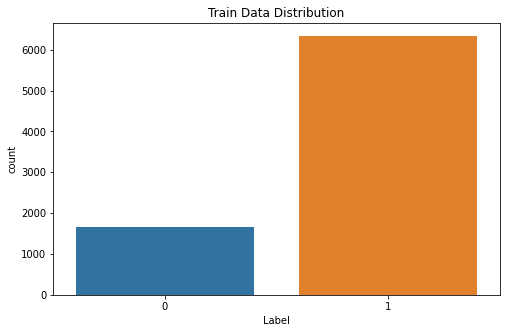

In [9]:
fig, ax = plt.subplots(figsize = (8,5))
sns.countplot(train_df["label"])
plt.xlabel("Label")
plt.title("Train Data Distribution");

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



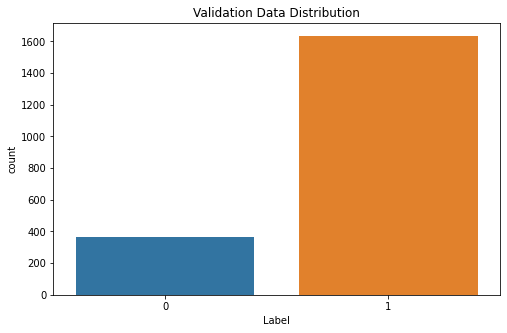

In [10]:
fig, ax = plt.subplots(figsize = (8,5))
sns.countplot(val_df["label"])
plt.xlabel("Label")
plt.title("Validation Data Distribution");

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



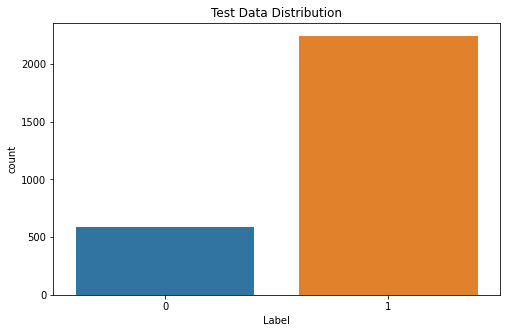

In [11]:
fig, ax = plt.subplots(figsize = (8,5))
sns.countplot(test_df["label"])
plt.xlabel("Label")
plt.title("Test Data Distribution");

## Wordclouds 

## Real label Word Cloud

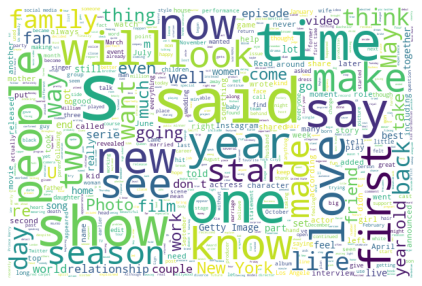

In [12]:
real_df = train_df[ train_df["label"] == 1 ]
real_text = " ".join(real_df["content"].values)


wordcloud_notes = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, max_font_size=120, max_words=5000,
                      width = 600, height = 400,
                      background_color='white').generate(real_text)
fig, ax = plt.subplots(figsize=(8,5))
ax.imshow(wordcloud_notes, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud_notes);

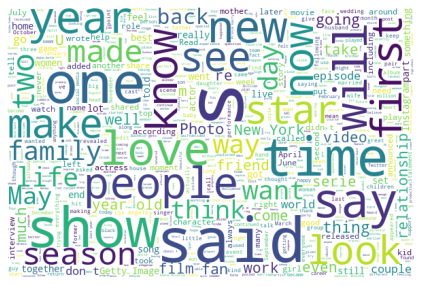

In [13]:
fake_df = train_df[ train_df["label"] == 0 ]
fake_text = " ".join(real_df["content"].values)


wordcloud_notes = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, max_font_size=120, max_words=5000,
                      width = 600, height = 400,
                      background_color='white').generate(fake_text)
fig, ax = plt.subplots(figsize=(8,5))
ax.imshow(wordcloud_notes, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud_notes);

## Custom Dataset

In [14]:
class CustomDataset(Dataset):
    def __init__(self, df, model_name_or_path, max_len, transform):
        super().__init__()
        
        ## train, test or val dataframe
        self.df = df.reset_index(drop = True)
        
        ## max length for text
        self.max_len = max_len
        
        ## transformer model tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
        
        ## image transforms
        self.transforms = transform

    def __getitem__(self, index):
        
        ## select row from dataframe
        row = self.df.iloc[index]
        
        ## open image
        try: 
            image = Image.open(row.img_path).convert('RGB')
        except:
            row = self.df.iloc[index+1]
            image = Image.open(row.img_path).convert('RGB')
            
        ## transform image    
        image = self.transforms(image)
        
        ## tokenize text
        inputs = self.tokenizer(
            row.content,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        
        ## input ids 
        ids = inputs['input_ids']
        ids = torch.LongTensor(ids)
        
        ## attention masks
        mask = inputs['attention_mask']
        mask = torch.LongTensor(mask)
        
        ## label
        label = row["label"]

        del inputs
        return ids, mask, image, label

    def __len__(self):
        
        ## returning lenght of dataframe
        return self.df.shape[0]

## Custom Model

In [15]:
class Multi_model(nn.Module):
    def __init__(self, model_path, hidden_dim, img_model_hidden_dim):
        super(Multi_model, self).__init__()
        
        ## transformer model
        self.model = AutoModel.from_pretrained(model_path)
        
        ## image model
        self.img_model = models.convnext_large(pretrained=True)
        
        ## chaning image model head
        self.img_model.classifier[2] = nn.Linear(1536, img_model_hidden_dim) #1536
        
        ## linear layer
        self.top = nn.Linear(hidden_dim + img_model_hidden_dim , 1)

    def forward(self, ids,mask,image):
        
        ## output of transformer model
        transformer_out = self.model(ids, mask)[0]
        
        ## output of image model
        img_out = self.img_model(image)
        
        ## concat of image and transformer output
        x = torch.cat((transformer_out[:, 0, :], img_out), 1)
        
        ## sigmoid layer
        x = self.top(x)
        return x

# Creating Dataloaders

In [16]:
## defining image transforms
transform=transforms.Compose([
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]), 
])

## loading train dataset
train_ds = CustomDataset(
    train_df, 
    config.MODEL_PATH, 
    config.MAX_LEN,
    transform
)

## loading validation dataset
val_ds = CustomDataset(
    val_df, 
    config.MODEL_PATH, 
    config.MAX_LEN,
    transform
)

## loading test dataset
test_ds = CustomDataset(
    test_df, 
    config.MODEL_PATH, 
    config.MAX_LEN,
    transform
)

## loading train dataloader
train_loader = DataLoader(train_ds, 
                          batch_size=config.BATCH_SIZE, 
                          shuffle=True, 
                          num_workers=config.NUM_WORKERS,
                          pin_memory=False, 
                          drop_last=True)

## loading validation dataloader
val_loader = DataLoader(val_ds, 
                          batch_size=config.BATCH_SIZE, 
                          shuffle=False, 
                          num_workers=config.NUM_WORKERS,
                          pin_memory=False, 
                          drop_last=False)
## loading test dataloader
test_loader = DataLoader(test_ds, 
                        batch_size= config.BATCH_SIZE,
                        shuffle=False, 
                        num_workers=config.NUM_WORKERS,
                        pin_memory=False, 
                        drop_last=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.7/site-packages/transformers/convert_slow_tokenizer.py:435: UserWarning:

The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabula

## Utility Functions

In [17]:
def read_data(data):
    """
    Function to read data
    """
    if config.GPU:
        return tuple(d.cuda() for d in data[:-1]), data[-1].cuda()
    else:
        return tuple(d for d in data[:-1]), data[-1]

def validate(model, val_loader):
    """
    Function to validate model on given dataloader
    """
    
    ## setting model to evaluation
    model.eval()
    
    ## setting up empty preds, labels and loss_list 
    preds = []
    labels = []
    loss_list = []
    
    ## Defining loss functions 
    criterion = torch.nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for data in tqdm(val_loader):
            inputs, target = read_data(data)
            
            with torch.cuda.amp.autocast():
                pred = model(*inputs)
                pred = pred.ravel()
                loss = criterion(pred.ravel(), target.float())
            ## appedning pred to main preds list
            preds.append(pred.detach().cpu().numpy().ravel())
            labels.append(target.detach().cpu().numpy().ravel())
            loss_list.append(loss.detach().cpu().item())
        val_loss = np.round(np.mean(loss_list), 4)
    
    preds = np.concatenate(preds)
    preds = nn.Sigmoid()(torch.LongTensor(preds)).numpy().round().astype("int")
    return np.concatenate(labels), preds, val_loss


def train(model, train_loader, val_loader, epochs):
    """
    Train Function 
    """
    ## listing parameters
    param_optimizer = list(model.named_parameters())
    
    ## seetting up parameters with no decay 
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    
    ## Optimizer setup
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    
    ## Defining  training steps 
    num_train_optimization_steps = int(config.EPOCHS * len(train_loader) / config.ACC_STEPS)
    
    ## setting up Optimizer
    optimizer = AdamW(optimizer_grouped_parameters, 
                      lr=config.LR,
                      correct_bias=False) 
    
    ## setting up learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps=0.2 * num_train_optimization_steps,
                                                num_training_steps=num_train_optimization_steps) 
      
    # defining loss    
    criterion = torch.nn.BCEWithLogitsLoss()
    
    ## defining scaler
    scaler = torch.cuda.amp.GradScaler()
    train_loss_out = []
    train_acc_out = []
    val_loss_out = []
    val_acc_out = []

    
    ## training loop
    for e in range(epochs):   
        
        model.train()
        tbar = tqdm(train_loader, file=sys.stdout)
        loss_list = []
        preds = []
        labels = []
        
        ## training
        for idx, data in enumerate(tbar):
            inputs, target = read_data(data)
            with torch.cuda.amp.autocast():
                pred = model(*inputs)
                loss = criterion(pred.ravel(), target.float())
            scaler.scale(loss).backward()
            if idx % config.ACC_STEPS == 0 or idx == len(tbar) - 1:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                scheduler.step()

            loss_list.append(loss.detach().cpu().item())
            preds.append(pred.detach().cpu().numpy().ravel())
            labels.append(target.detach().cpu().numpy().ravel())
            train_loss = np.round(np.mean(loss_list), 4)
            
            acc_bar_preds = np.concatenate(preds)
            acc_bar_preds = nn.Sigmoid()(torch.LongTensor(acc_bar_preds)).numpy().round().astype("int")
            acc_bar = round(accuracy_score(np.concatenate(labels), acc_bar_preds), 2 )
            

            tbar.set_description(f"Epoch {e + 1} Loss: {train_loss}  Accuracy: {acc_bar}")
            
        preds_acc = np.concatenate(preds)
        preds_acc = nn.Sigmoid()(torch.LongTensor(preds_acc)).numpy().round().astype("int")
        train_acc = np.round(accuracy_score(np.concatenate(labels),preds_acc),4)
        train_loss_out.append(train_loss)
        train_acc_out.append(train_acc)
        print("Train Accuracy:", train_acc)
        if config.SAVE_MODEL:
            torch.save(model.state_dict(),config.MODEL_SAVE_PATH)

        if config.EVALUATE:
            print("Performing Validation: ")
            
            y_val, y_pred, val_loss = validate(model, val_loader)
            y_pred = y_pred.round().astype("int")
            val_acc = np.round(accuracy_score(y_val,y_pred),4)
            val_loss_out.append(val_loss)
            val_acc_out.append(val_acc)
            
            print("Validation Accuracy:", val_acc)
            

    print("TRAINING FINISHED!!!")
    if config.EVALUATE: 
        return model, y_pred, y_val, train_loss_out, train_acc_out, val_loss_out, val_acc_out
    else:
        return model , 0, 0, 0 

## Training Model

In [18]:

## instaniating model 
model = Multi_model(
    config.MODEL_PATH, 
    config.MODEL_HIDDEN_STATE_DIM,
    config.IMG_MODEL_HIDDEN_DIM
)


## moving model to gpu
if config.GPU:
    model = model.cuda()

## training model 
if config.TRAIN:
    model, preds, labels, train_loss, train_acc, val_loss, val_acc = train(model, train_loader, val_loader, config.EPOCHS)

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python

  0%|          | 0/500 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



Train Accuracy: 0.6164
Performing Validation: 


  0%|          | 0/177 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



Validation Accuracy: 0.8452


  0%|          | 0/500 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



Train Accuracy: 0.8102
Performing Validation: 


  0%|          | 0/177 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



Validation Accuracy: 0.8498


  0%|          | 0/500 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



Train Accuracy: 0.8571
Performing Validation: 


  0%|          | 0/177 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



Validation Accuracy: 0.8809


  0%|          | 0/500 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



Train Accuracy: 0.8778
Performing Validation: 


  0%|          | 0/177 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



Validation Accuracy: 0.8753


  0%|          | 0/500 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



Train Accuracy: 0.8952
Performing Validation: 


  0%|          | 0/177 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



Validation Accuracy: 0.8954


  0%|          | 0/500 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



Train Accuracy: 0.9031
Performing Validation: 


  0%|          | 0/177 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



Validation Accuracy: 0.9021
TRAINING FINISHED!!!


## Training Plots 

In [19]:
## history for plots of loss and accuracies 
history = pd.DataFrame([train_loss, train_acc, val_loss, val_acc]).T
history = history.rename(columns = {0:"Train Loss",1:"Train Accuracy",2:"Validation Loss", 3:"Validation Accuracy"})

In [20]:
x = px.line(data_frame= history , y= ["Train Accuracy" , "Validation Accuracy"] ,markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [21]:
x = px.line(data_frame= history , 
            y= ["Train Loss" , "Validation Loss"] , markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

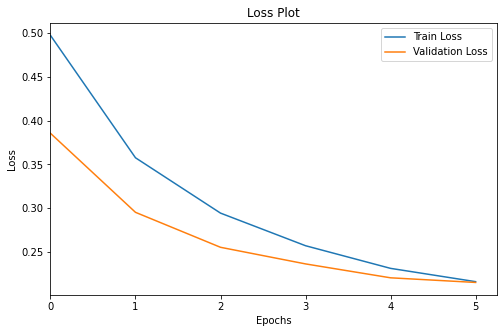

In [22]:
fig, ax = plt.subplots(figsize = (8,5))
plt.plot(history["Train Loss"], label = "Train Loss")
plt.plot(history["Validation Loss"], label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
ax.set_xlim(xmin=0)
plt.title("Loss Plot");

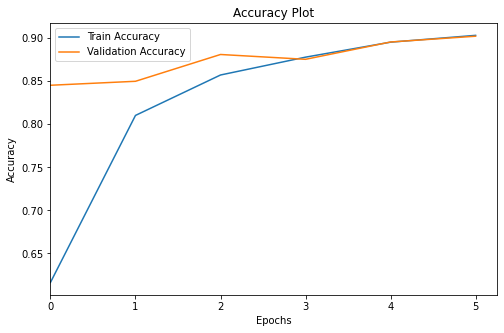

In [23]:
fig, ax = plt.subplots(figsize = (8,5))
plt.plot(history["Train Accuracy"], label = "Train Accuracy")
plt.plot(history["Validation Accuracy"], label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
ax.set_xlim(xmin=0)
plt.title("Accuracy Plot");

## Model Evaluation 

In [24]:
def test_evaluate(model, test_loader):
    """
    Function to validate model on given dataloader
    """
    model.eval()
    preds = []
    labels = []
    loss_list = []
    criterion = torch.nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for data in tqdm(test_loader):
            inputs, target = read_data(data)

            with torch.cuda.amp.autocast():
                pred = model(*inputs)
                pred = pred.ravel()
                loss = criterion(pred.ravel(), target.float())
            preds.append(pred.detach().cpu().numpy().ravel())
            labels.append(target.detach().cpu().numpy().ravel())
            loss_list.append(loss.detach().cpu().item())
        val_loss = np.round(np.mean(loss_list), 4)
    
    preds = np.concatenate(preds)
    pred_probs = nn.Sigmoid()(torch.LongTensor(preds)).numpy()
    preds = pred_probs.round().astype("int")
    return np.concatenate(labels), preds, pred_probs, val_loss

y_test, y_preds, pred_probs, loss = test_evaluate(model, test_loader)
print("Test Accuracy = ", accuracy_score(y_test, y_preds))

  0%|          | 0/177 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



Test Accuracy =  0.9021201413427562


### Confusion Matrix

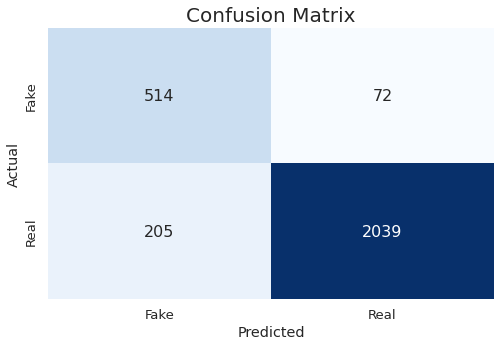

In [31]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (8,5))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

### Classification Report 

In [32]:
print(classification_report(y_test, y_preds, digits = 4 ))

              precision    recall  f1-score   support

           0     0.7149    0.8771    0.7877       586
           1     0.9659    0.9086    0.9364      2244

    accuracy                         0.9021      2830
   macro avg     0.8404    0.8929    0.8621      2830
weighted avg     0.9139    0.9021    0.9056      2830



### ROC AUC Score 

In [33]:
print("ROC-AUC Score  = " ,roc_auc_score(y_test , pred_probs))

ROC-AUC Score  =  0.9462959245131499


### ROC AUC Curve

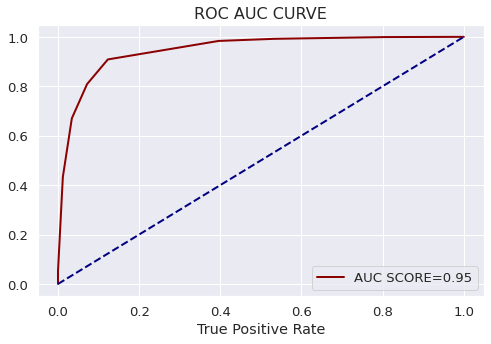

In [34]:
fpr, tpr, thresholds  = roc_curve(y_test, pred_probs)
auc = roc_auc_score(y_test, pred_probs)
plt.figure(figsize = (8,5))
plt.plot(fpr,tpr,color='darkred', lw=2, label="AUC SCORE="+str(round(auc,2)))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC AUC CURVE', fontsize = 16)
plt.xlabel("False Positive Rate")
plt.xlabel("True Positive Rate")
plt.legend(loc=4)
plt.show()

## Saving Predictions 

In [35]:
test_df["predictions"] = y_preds
test_df.to_csv("preds.csv", index = False)
test_df.head()

,Unnamed: 0,content,image,label,img_path,img_check_2,predictions
0,0,One Love Manchester: Katy Perry wears photos o...,DyweiEOWJPtOqslc31CyVnTCyvAm307J.jpg,1,../input/frmultimodalpg/Images/gossip_test/Dyw...,True,1
1,1,TLC cuts all ties with Derick Dillard after mo...,NSq6JnA5ziOJbAQCzVlfti3OymZvInGK.jpg,1,../input/frmultimodalpg/Images/gossip_test/NSq...,True,1
2,2,Cher Steals the Show at the 2017 Billboard Mus...,00E2lj9GCBAWZkyF5LJnZapSxApvHRpL.jpg,1,../input/frmultimodalpg/Images/gossip_test/00E...,True,1
3,3,Thomas Rhett's Daughter Willa Gray Steals Show...,00PeQayaonj6NADaacrhVYWOkOE6eCGt.jpg,1,../input/frmultimodalpg/Images/gossip_test/00P...,True,1
4,4,2019 Spring/Summer TV Premiere Calendar FRI / ...,017RaNdh1e3FTgXu4kaLoobyPijDauzd.jpg,1,../input/frmultimodalpg/Images/gossip_test/017...,True,1


## Model Summary 

In [36]:
model

Multi_model(
  (model): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0): DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
              (dropout): S